In [1]:
#UNSUPERVISED CLASSIFICATION

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
PATH = 'D:\\E4\\1606\\' 
FILENAME = 'subset_0_of_projected_Subset_S2A_MSIL2A_20180409T101031_N0207_R022_T33UVS_20180409T154909_resampled_wt.nc'
ds = xr.open_dataset(PATH+FILENAME)  # loading dataset

In [ ]:
ds

In [ ]:
#First, we reduce our dataset so that just the spectral bands are used for our analysis.

ds_reduced = ds[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']]
ds_reduced

In [6]:
#Formel für NDVI
def NDVI(ds_reduced):
    ds_reduced['NDVI']=(ds_reduced.B8 - ds_reduced.B4)/(ds_reduced.B8 + ds_reduced.B4)  # Hinzufügen des neuen Bandes NDVI zum Datensatz

In [7]:
#NDVI
NDVI(ds_reduced)

In [8]:
def plotting(ds,vmin='NULL',vmax='NULL',cmap='NULL',title='NULL'):
    fig, ax = plt.subplots(figsize=(12,10))
    ds.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap)
    plt.tight_layout();
    title=title
    plt.title(title, fontsize=22) 

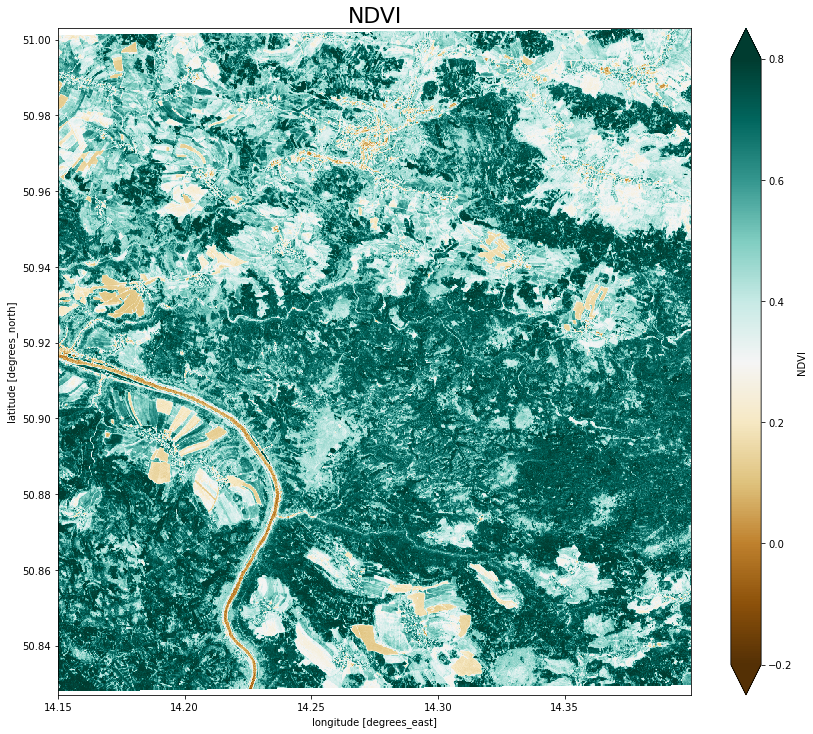

In [9]:
plotting(ds_reduced.NDVI,vmin=-0.2,vmax=0.8, cmap='BrBG',title='NDVI')

In [10]:
# Formel für BRI
def BRI (ds_reduced):
    ds_reduced['BRI'] = (1/1550)  - (1/700) / ds_reduced.B8

In [11]:
#BRI
BRI(ds_reduced)

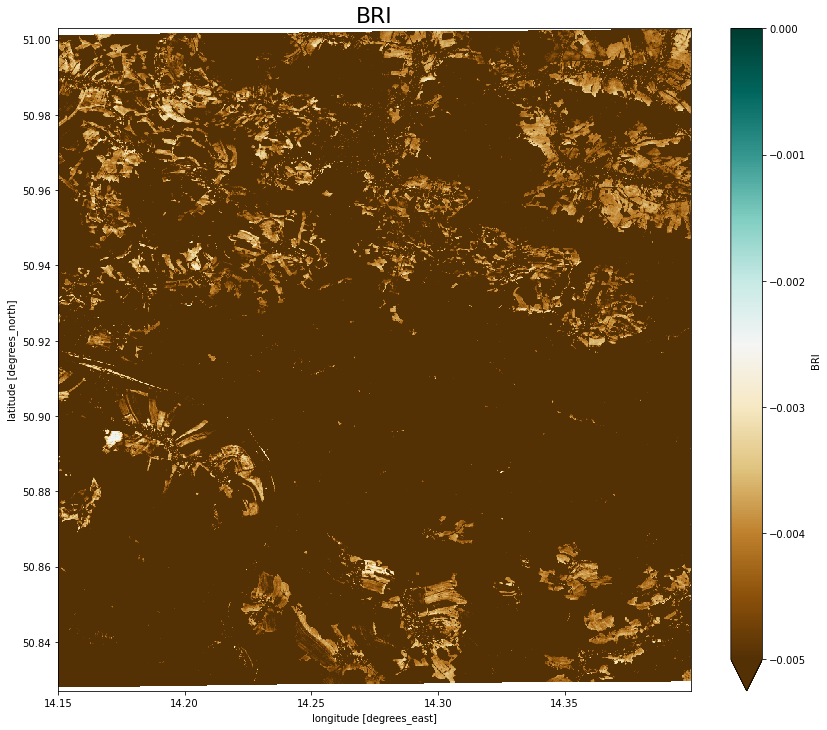

In [12]:
plotting(ds_reduced.BRI,vmin=-0.005,vmax=0.0, cmap='BrBG',title='BRI')

In [13]:
#Formel für GVI
def GVI(ds_reduced):
    ds_reduced['GVI'] = -0.2848 * ds_reduced.B2 - 0.24 * ds_reduced.B3 - 0.5436 * ds_reduced.B4 + 0.7243 * ds_reduced.B8 + 0.0840 * ds_reduced.B11 - 0.1800 * ds_reduced.B12

In [14]:
#GVI
GVI(ds_reduced)

In [15]:
#Formel für WET
def WET(ds_reduced):
    ds_reduced['WET'] = 0.1509 * ds_reduced.B2 +0.1973 * ds_reduced.B3 + 0.3279 * ds_reduced.B4 + 0.3406 * ds_reduced.B8 - 0.7112 * ds_reduced.B11 - 0.4572 * ds_reduced.B12

In [16]:
#WET
WET(ds_reduced)

In [ ]:
#Convert the xarray to a pandas dataframe in order to apply clustering and PCA afterwards

df = ds_reduced.to_dataframe()  # converting to pandas dataframe
df

In [18]:
#NANs

df.isnull().values.any()  # check if there are any NaNs
df.isnull().sum().sum()  # counting the NaNs in the whole dataframe, sum across columns and rows

714160

In [19]:
#deleting NANs

df = ds_reduced.to_dataframe().dropna(how='any')
df.isnull().sum().sum()

0

In [20]:
#kmeans clustering

n_clusters = 20 #number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0) # init k-means model 
kmeans.fit_predict(df) # apply k-means to data 
print(kmeans.labels_)   # show the cluster number for each data point 

[ 8  8 17 ...  8  8  8]


In [21]:
#Copy the dataframe to a new dataframe and add the cluster label for each pixel.

df_cluster = df
df_cluster['KMeanCluster'] = kmeans.labels_  # adding the labels to our dataset


In [ ]:
#NEW COLUMN FOR LABELING

df_cluster['ClusterNumber'] = df_cluster.KMeanCluster

df_cluster

In [ ]:
#Convert the clustering result back to xarray to make a map and save the result as NetCDF.

ds_cluster = df_cluster.to_xarray()  # converting the dataframe to an xarray dataset for easy plotting
ds_cluster = ds_cluster.sortby('lon')  # and sorting the longitude to avoid raising an error while plotting and being able
                                       # to save the data correctly
ds_cluster

In [24]:
SAVING_FILENAME = "new_kmeans_clustered_subset_april_of_projected_Subset_S2A_MSIL2A_20180409T101031_N0207_R022_T33UVS_20180409T154909_resampled_wt.nc"
ds_cluster.to_netcdf(PATH + SAVING_FILENAME)

In [25]:
#Defines a function to plot the clustering result as a thematic map

def plotting_lc(ds,cmap='NULL', variable='NULL',n_clusters='NULL',legend_labels='NULL',title='NULL'):  # modifying plotting function to achieve a discrete colorbar
    ds = ds.sortby('lat', ascending=False)
    
    fig, ax = plt.subplots(figsize=(15,10), dpi=100)
    ax.imshow(ds[variable],cmap=cmap, aspect='auto')
    
    # specifying legend
    norm= colors.BoundaryNorm(np.arange(0,n_clusters+1)-0.5, n_clusters)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ticks=np.arange(0,n_clusters), fraction=0.042, pad=0.02)

    cbar.set_label('cluster')
    cbar.ax.set_yticklabels(legend_labels)
    
    # specifiying x- and y-axis
    lon_ticks = np.around(np.linspace(ds.lon.data.min(), ds.lon.data.max(), 6), 2)
    lon_ticks_pos = np.linspace(0, len(ds.lon.data), 6)
    lat_ticks = np.around(np.linspace(ds.lat.data.max(), ds.lat.data.min(), 6), 2)
    lat_ticks_pos = np.linspace(0, len(ds.lat.data), 6)
    ax.set_xticks(lon_ticks_pos)
    ax.set_xticklabels(lon_ticks)
    ax.set_yticks(lat_ticks_pos)
    ax.set_yticklabels(lat_ticks)
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    
    plt.tight_layout()
    plt.title(title, fontsize=22)
    
    #plt.savefig('D:\\E4\\kmeans_clustering_april_new.png')

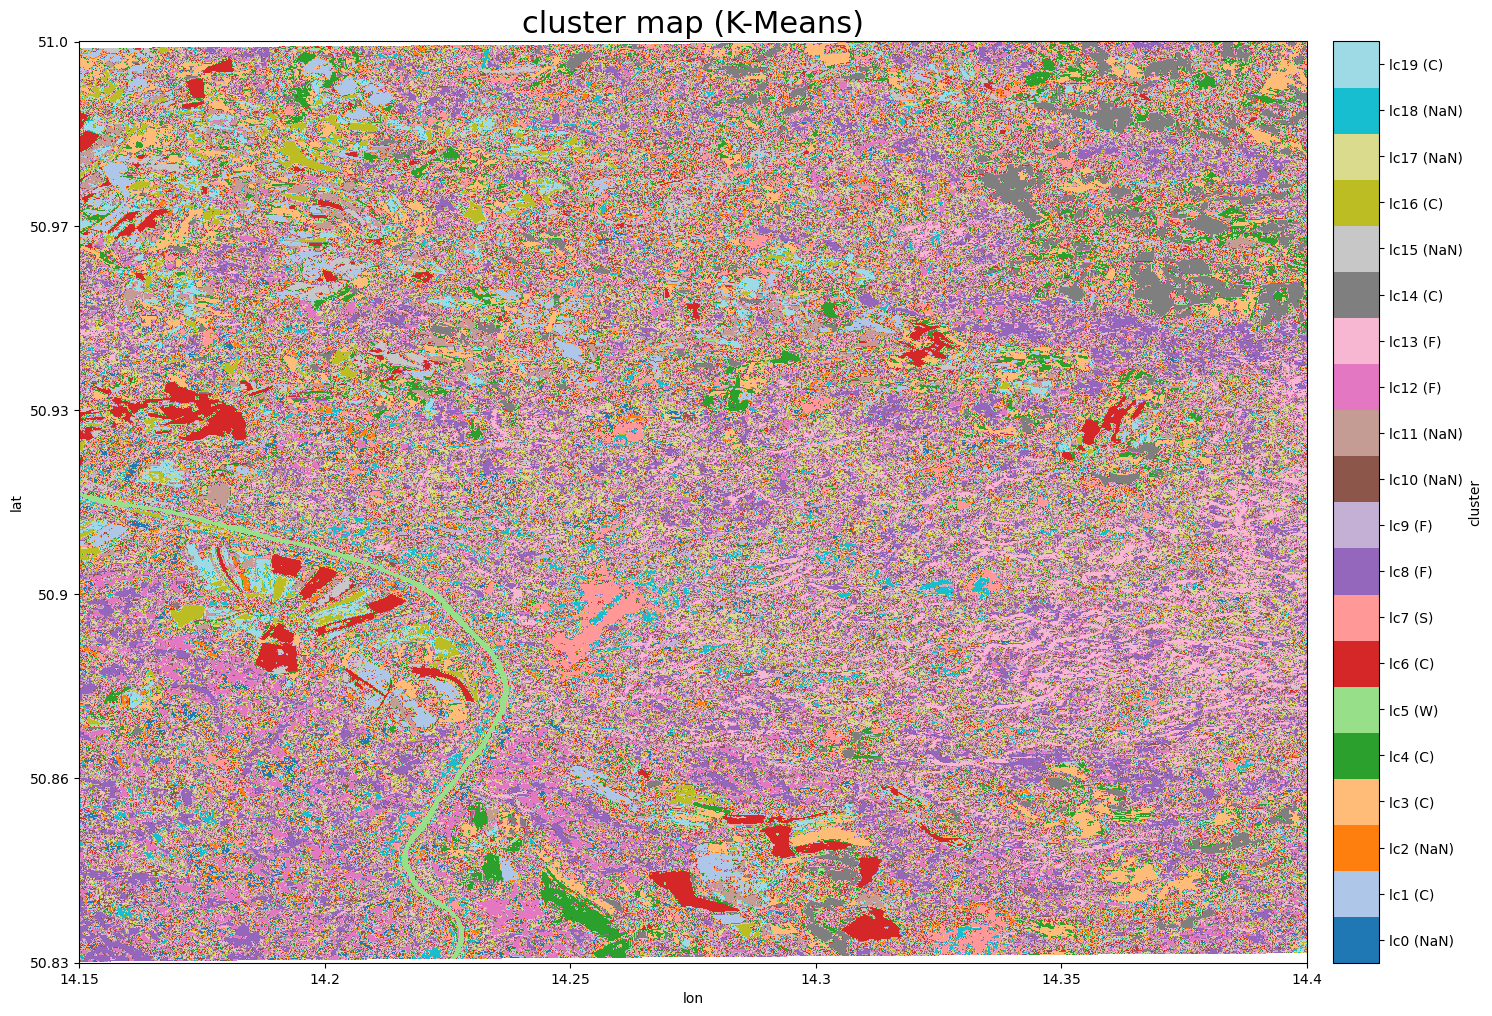

In [27]:
cmap = plt.cm.get_cmap('tab20', n_clusters)  # create colormap
legend_labels = ['lc0 (NaN)', 'lc1 (C)', 'lc2 (NaN)', 'lc3 (C)', 'lc4 (C)', 'lc5 (W)', 'lc6 (C)', 'lc7 (S)', 'lc8 (F)', 'lc9 (F)','lc10 (NaN)', 'lc11 (NaN)', 'lc12 (F)', 'lc13 (F)' , 'lc14 (C)', 'lc15 (NaN)', 'lc16 (C)', 'lc17 (NaN)', 'lc18 (NaN)', 'lc19 (C)']  # define legend labels
title = 'cluster map (K-Means)'  # set figure title

plotting_lc(ds_cluster, variable='KMeanCluster', n_clusters=n_clusters, cmap=cmap, legend_labels=legend_labels,
            title=title)

In [ ]:
#21 = crop, 22 = forest, 23 = water, 24 = soil, NaN = NaN

In [ ]:
df_cluster['ClusterNumber'] = df_cluster['ClusterNumber'].replace([1,3,4,6,14,16,19],21)
df_cluster['ClusterNumber'] = df_cluster['ClusterNumber'].replace([8,9,12,13],22)
df_cluster['ClusterNumber'] = df_cluster['ClusterNumber'].replace([5],23)
df_cluster['ClusterNumber'] = df_cluster['ClusterNumber'].replace([7],24)
df_cluster['ClusterNumber'] = df_cluster['ClusterNumber'].replace([0,2,17, 10, 11,15,18],'NaN')

df_cluster

In [37]:
#LÖSCHEN
index_names = df_cluster[df_cluster['ClusterNumber'] == 'NaN'].index

index_names


MultiIndex([(51.00252059406566,    14.368791115333),
            (51.00252059406566,   14.3688825953564),
            (51.00252059406566,   14.3712610759648),
            (51.00252059406566,   14.3713525559882),
            (51.00252059406566,   14.3714440360116),
            (51.00252059406566, 14.372999196409399),
            (51.00252059406566, 14.373548076549799),
            (51.00252059406566, 14.374645836830599),
            (51.00252059406566, 14.374737316853999),
            (51.00252059406566, 14.374828796877399),
            ...
            (  50.828159669453, 14.153538620272844),
            (  50.828159669453, 14.153630100296244),
            (  50.828159669453, 14.153721580319644),
            (  50.828159669453, 14.153813060343044),
            (  50.828159669453, 14.153904540366444),
            (  50.828159669453, 14.153996020389844),
            (  50.828159669453, 14.155734140834443),
            (  50.828159669453, 14.155825620857843),
            (  50.828159669453

In [38]:
df_cluster.drop(index_names , inplace=True)

In [ ]:
#df_cluster['ClusterNumber'] = df_cluster.to_string(df_cluster['ClusterNumber'])

In [ ]:
uniques = df_cluster.ClusterNumber.drop_duplicates()

print(uniques)

In [39]:
df_cluster['ClusterNumber'] = pd.to_numeric(df_cluster['ClusterNumber'],errors = 'coerce')

In [ ]:
df_cluster

In [ ]:
#Convert the clustering result back to xarray to make a map and save the result as NetCDF.

ds_cluster = df_cluster.to_xarray()  # converting the dataframe to an xarray dataset for easy plotting
ds_cluster = ds_cluster.sortby('lon')  # and sorting the longitude to avoid raising an error while plotting and being able
                                       # to save the data correctly
ds_cluster

In [42]:
SAVING_FILENAME = "new_new_kmeans_clustered_subset_april_of_projected_Subset_S2A_MSIL2A_20180409T101031_N0207_R022_T33UVS_20180409T154909_resampled_wt.nc"
ds_cluster.to_netcdf(PATH + SAVING_FILENAME)

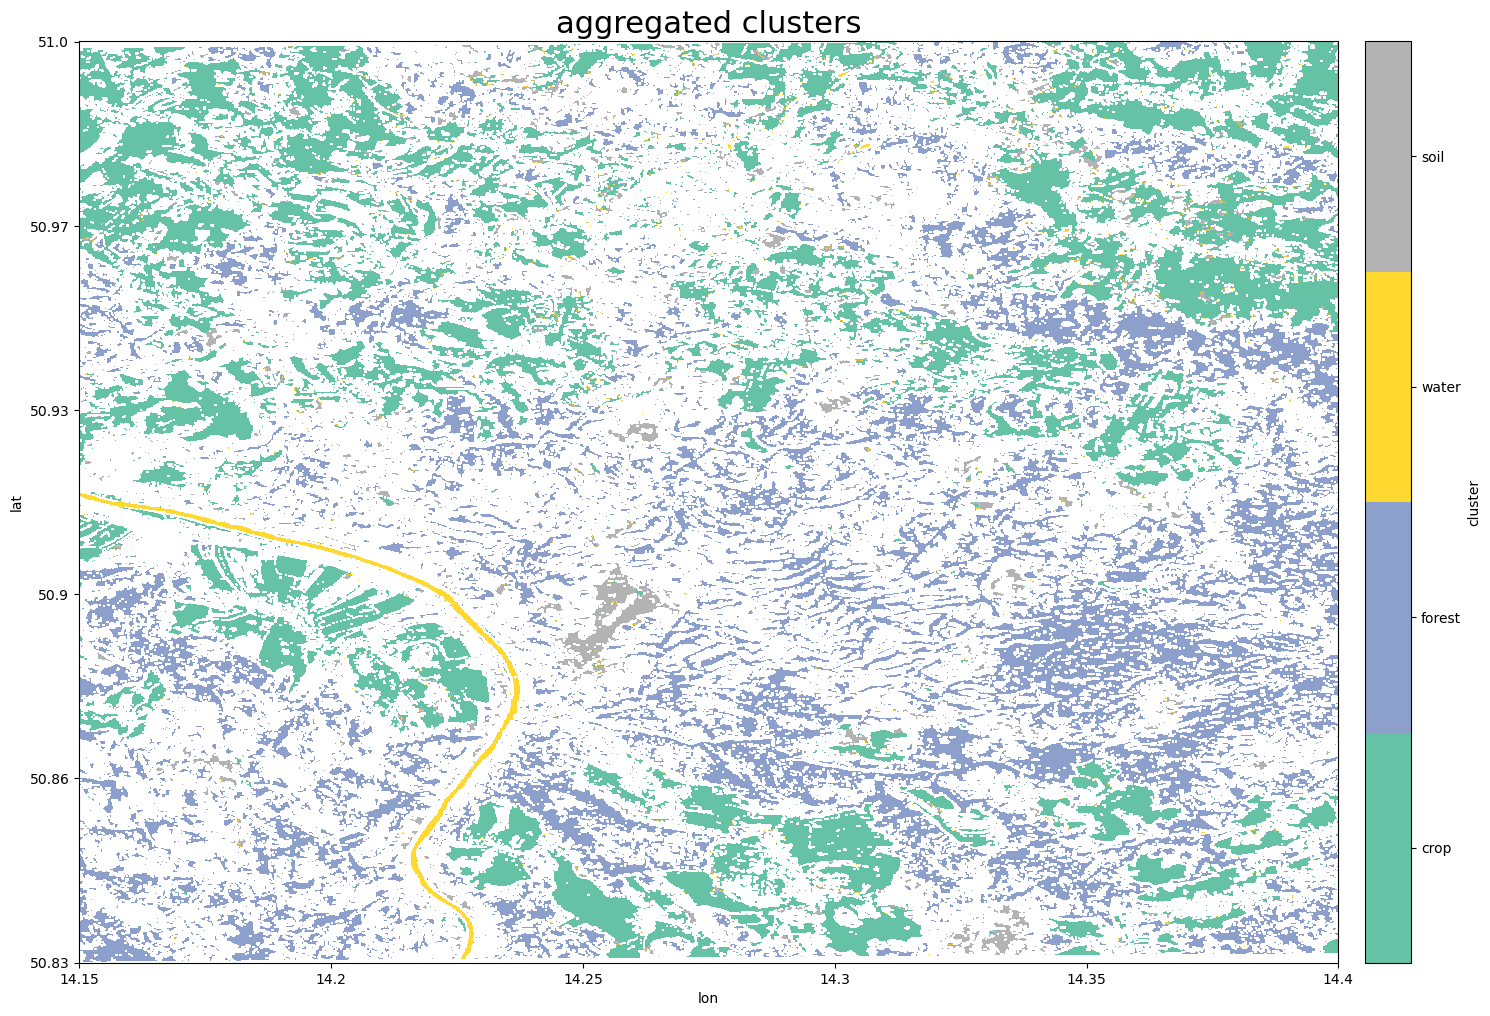

In [43]:
cmap = plt.cm.get_cmap('Set2', 4)  # create colormap
legend_labels = ['crop', 'forest', 'water', 'soil']  # define legend labels
title = 'aggregated clusters'  # set figure title

plotting_lc(ds_cluster, variable='ClusterNumber', n_clusters=4, cmap=cmap, legend_labels=legend_labels,
            title=title)

plt.savefig('D:\\E4\\kmeans_aggregated_clusters.png')

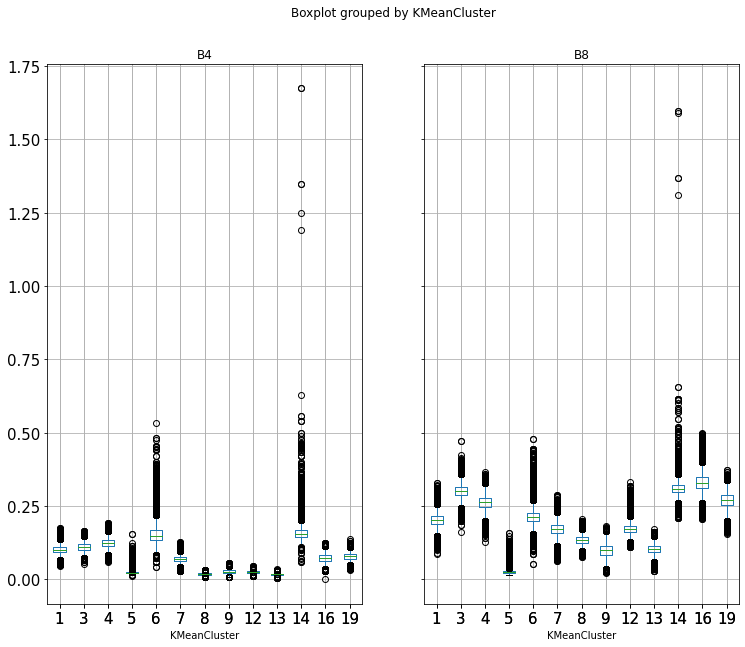

In [44]:
#You can also plot a boxplot to look at the distribution of reflectances in each cluster.

boxplot = df_cluster.boxplot(column=['B4', 'B8'], by='KMeanCluster', figsize=(12,10), fontsize=15)
plt.savefig('D:\\E4\\boxplot_kmeans_clustering_april')

In [ ]:
#JOIN REFERENCE DATA

In [45]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

In [ ]:
#opening the clustered data as reference
PATH = 'D:\\E4\\1606\\' 
FILENAME = 'new_new_kmeans_clustered_subset_april_of_projected_Subset_S2A_MSIL2A_20180409T101031_N0207_R022_T33UVS_20180409T154909_resampled_wt.nc'
ds_1 = xr.open_dataset(PATH+FILENAME)

ds_1.ClusterNumber

In [35]:
uniques = df_reference1.ClusterNumber.drop_duplicates()

print(uniques)

lat        lon      
51.002521  14.149971     NaN
           14.368608    22.0
           14.376110    24.0
           14.377482    21.0
50.996666  14.302377    23.0
Name: ClusterNumber, dtype: float64


In [ ]:
#opening the sachsenforst data as reference
PATH = 'D:\\E4\\1606\\' 
FILENAME = 'subset_0_of_borkenkaeferbefall2018.nc'
ds_2 = xr.open_dataset(PATH+FILENAME)

ds_2.befall2018

In [ ]:
combined_ds = xr.open_mfdataset(['D:\\E4\\1606\\new_kmeans_clustered_subset_april_of_projected_Subset_S2A_MSIL2A_20180409T101031_N0207_R022_T33UVS_20180409T154909_resampled_wt.nc', 'D:\\E4\\1606\\subset_0_of_borkenkaeferbefall2018.nc'],combine = 'by_coords')

combined_ds

In [ ]:
combined_ds['ClusterNumber2'] = combined_ds.ClusterNumber.where(combined_ds['befall2018'] !=1, 10)

combined_ds

In [88]:
combined_df = combined_ds.to_dataframe()  # converting to pandas dataframe
combined_df.ClusterNumber2

lat        lon      
50.827062  14.149971   NaN
           14.150062   NaN
           14.150154   NaN
           14.150245   NaN
           14.150337   NaN
                        ..
51.002887  14.399528   NaN
           14.399620   NaN
           14.399711   NaN
           14.399803   NaN
           14.399894   NaN
Name: ClusterNumber2, Length: 2629146, dtype: float64

In [89]:
#NANs

combined_df.ClusterNumber2.isnull().values.any()  # check if there are any NaNs
combined_df.ClusterNumber2.isnull().sum().sum()  # counting the NaNs in the whole dataframe, sum across columns and rows

1040691

In [91]:
#LÖSCHEN
index_names = combined_df[combined_df['ClusterNumber2'].isnull()].index

index_names

MultiIndex([( 50.82706190917212, 14.149970899360245),
            ( 50.82706190917212, 14.150062379383645),
            ( 50.82706190917212, 14.150153859407045),
            ( 50.82706190917212, 14.150245339430445),
            ( 50.82706190917212, 14.150336819453845),
            ( 50.82706190917212, 14.150428299477245),
            ( 50.82706190917212, 14.150519779500645),
            ( 50.82706190917212, 14.150611259524045),
            ( 50.82706190917212, 14.150702739547445),
            ( 50.82706190917212, 14.150794219570844),
            ...
            (51.002886514159286, 14.399071003078394),
            (51.002886514159286, 14.399162483101794),
            (51.002886514159286, 14.399253963125194),
            (51.002886514159286, 14.399345443148594),
            (51.002886514159286, 14.399436923171994),
            (51.002886514159286, 14.399528403195394),
            (51.002886514159286, 14.399619883218794),
            (51.002886514159286, 14.399711363242194),
            

In [92]:
combined_df.drop(index_names , inplace=True)

In [ ]:
#Convert the clustering result back to xarray to make a map and save the result as NetCDF.

ds_reference = combined_df.to_xarray()  # converting the dataframe to an xarray dataset for easy plotting
ds_reference = ds_reference.sortby('lon')  # and sorting the longitude to avoid raising an error while plotting and being able
                                       # to save the data correctly
ds_reference

In [64]:
uniques = df_ohne_NAN.new_reference.drop_duplicates()

print(uniques)

lat        lon      
50.828160  14.149971    22.0
50.828526  14.150062    24.0
50.828709  14.225625    23.0
50.828892  14.255173    21.0
50.885792  14.308872    10.0
Name: new_reference, dtype: float64


In [ ]:
#Convert the clustering result back to xarray to make a map and save the result as NetCDF.

ds_ohne_NAN = df_ohne_NAN.to_xarray()  # converting the dataframe to an xarray dataset for easy plotting

ds_ohne_NAN

In [71]:
df_ohne_NAN.ClusterNumber.value_counts()

22.0    774998
21.0    618954
24.0    168039
23.0     12517
Name: ClusterNumber, dtype: int64

In [73]:
df_ohne_NAN.new_reference.value_counts()

22.0    749056
21.0    618938
24.0    167996
10.0     26001
23.0     12517
Name: new_reference, dtype: int64

In [82]:
df_ohne_NAN2 = ds_ohne_NAN.to_dataframe()  # converting to pandas dataframe
df_ohne_NAN2.new_reference.value_counts()

22.0    749056
21.0    618938
24.0    167996
10.0     26001
23.0     12517
Name: new_reference, dtype: int64

In [ ]:
cmap = plt.cm.get_cmap('Accent', 5)  # create colormap
legend_labels = ['bark beetle', 'crop', 'forest', 'crop','forest']  # define legend labels
title = 'new clusters'  # set figure title

plotting_lc(ds_reference, variable='ClusterNumber2', n_clusters=5, cmap=cmap, legend_labels=legend_labels,
            title=title)

In [95]:
ds_reference['reference_data'] = ds_reference.ClusterNumber2

In [ ]:
ds_reference

In [97]:
SAVING_FILENAME = "ds_reference_clustered_subset_april_of_projected_Subset_S2A_MSIL2A_20180409T101031_N0207_R022_T33UVS_20180409T154909_resampled_wt.nc"
ds_reference.to_netcdf(PATH + SAVING_FILENAME)

In [ ]:
#SUPERVISED CLASSIFICATION

In [2]:
PATH = 'D:\\E4\\1606\\'
FILENAME_2018 = "projected_Subset_S2A_MSIL2A_20180409T101031_N0207_R022_T33UVS_20180409T154909_resampled_wt.nc"
FILENAME_2019 = "projected_Subset_S2B_MSIL2A_20190419T101029_N0211_R022_T33UVS_20190419T132322_resampled_wt.nc"
FILENAME_REF_2018 = "ds_reference_clustered_subset_april_of_projected_Subset_S2A_MSIL2A_20180409T101031_N0207_R022_T33UVS_20180409T154909_resampled_wt.nc"
FILENAME_REF_2019 = "barkbeetlearea2019.nc"
data2018 = PATH + FILENAME_2018
data2019 = PATH + FILENAME_2019
ref2018 = PATH + FILENAME_REF_2018
ref2019 = PATH + FILENAME_REF_2019

In [5]:
ds_sc = xr.open_mfdataset([data2018, data2019, ref2018, ref2019])  # this is an option to open and instantly merge the data into one dataset
ds_sc = ds_sc.drop('spatial_ref')
ds_sc

<xarray.Dataset>
Dimensions:                       (lat: 2879, lon: 7714, time: 3)
Coordinates:
  * lat                           (lat) float64 50.83 50.83 50.83 ... 51.0 51.0
  * lon                           (lon) float64 14.0 14.0 14.0 ... 14.45 14.45
  * time                          (time) datetime64[ns] 2018-04-09 ... 2019-0...
Data variables: (12/58)
    B1                            (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    B2                            (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    B3                            (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    B4                            (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    B5                            (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    B6                            (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    ...                            ...
    view_azimuth_B10              (time, lat, lon) float32 dask.array<chunksize=(1, 2879, 7714), meta=np.ndarray>
    view_zenith_B11               (time, lat, lon) float32 dask.array<chunksize=(1, 2879, 7714), meta=np.ndarray>
    view_azimuth_B11              (time, lat, lon) float32 dask.array<chunksize=(1, 2879, 7714), meta=np.ndarray>
    view_zenith_B12               (time, lat, lon) float32 dask.array<chunksize=(1, 2879, 7714), meta=np.ndarray>
    view_azimuth_B12              (time, lat, lon) float32 dask.array<chunksize=(1, 2879, 7714), meta=np.ndarray>
    befall2019                    (time, lat, lon) float32 dask.array<chunksize=(3, 2879, 7714), meta=np.ndarray>

In [6]:
ds_sc = ds_sc[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'BRI', 'GVI', 'WET', 'reference_data', 'befall2019']]
ds_sc

<xarray.Dataset>
Dimensions:         (lat: 2879, lon: 7714, time: 3)
Coordinates:
  * lat             (lat) float64 50.83 50.83 50.83 50.83 ... 51.0 51.0 51.0
  * lon             (lon) float64 14.0 14.0 14.0 14.0 ... 14.45 14.45 14.45
  * time            (time) datetime64[ns] 2018-04-09 2019-04-19 2019-09-21
Data variables: (12/18)
    B1              (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    B2              (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    B3              (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    B4              (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    B5              (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    B6              (lat, lon, time) float32 dask.array<chunksize=(2879, 7714, 1), meta=np.ndarray>
    ...              ...
    NDVI            (lat, lon) float32 dask.array<chunksize=(2879, 7714), meta=np.ndarray>
    BRI             (lat, lon) float32 dask.array<chunksize=(2879, 7714), meta=np.ndarray>
    GVI             (lat, lon) float32 dask.array<chunksize=(2879, 7714), meta=np.ndarray>
    WET             (lat, lon) float32 dask.array<chunksize=(2879, 7714), meta=np.ndarray>
    reference_data  (lat, lon) float64 dask.array<chunksize=(2879, 7714), meta=np.ndarray>
    befall2019      (time, lat, lon) float32 dask.array<chunksize=(3, 2879, 7714), meta=np.ndarray>

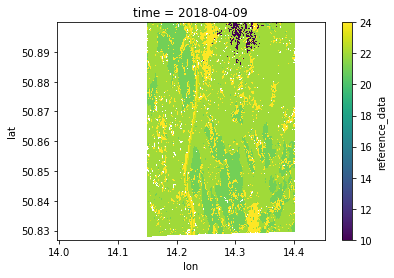

In [7]:
ds_train = ds_sc.sel(**{'time':'2018-04-09', 'lat': slice(None, 50.9)})
ds_train.reference_data.plot()  # have a quick look on the data

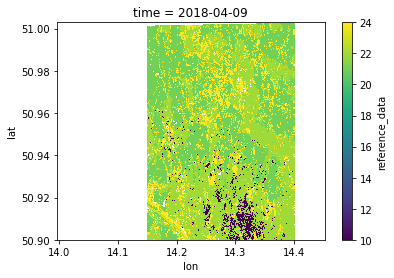

In [8]:
ds_test = ds_sc.sel(**{'time':'2018-04-09', 'lat': slice(50.9, None)})
ds_test.reference_data.plot()

In [ ]:
df_train = ds_train[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'BRI', 'GVI', 'WET', 'reference_data']].to_dataframe().dropna(how='any')
df_train

In [ ]:
df_test = ds_test[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'BRI', 'GVI', 'WET', 'reference_data']].to_dataframe().dropna(how='any')
df_test

In [11]:
#Now we have training and test data. The last step before applying machine learning is to define predictor and target variables. 
#The target variable 'y' is the land cover classification (reference data) described by the predictors 'X', the reflectances.

df_train = df_train[df_train.reference_data != 0]  # use only the cells, which are classified
df_test = df_test[df_test.reference_data != 0]

X_train = df_train[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'BRI', 'GVI', 'WET']]  # Features
y_train = df_train['reference_data']  # target variable

X_test = df_test[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'BRI', 'GVI', 'WET']]
y_test = df_test['reference_data']

y_train

lat       lon      
50.82816  14.149971    22.0
          14.150062    22.0
          14.150154    22.0
          14.150245    22.0
          14.150337    22.0
                       ... 
50.89988  14.399528    22.0
          14.399620    22.0
          14.399711    22.0
          14.399803    22.0
          14.399894    22.0
Name: reference_data, Length: 654078, dtype: float64

In [12]:
%%time
# This is a magic function to measure the execution time of a cell, which will be plotted below the cell. It has to be 
# written in the first line of the cell.

# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
clf_rf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets 
clf_rf.fit(X_train,y_train)

# apply the random forest to the test data
y_pred_rf = clf_rf.predict(X_test)

y_pred_rf

Wall time: 6min 31s


array([21., 21., 21., ..., 21., 21., 21.])

In [13]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# compute the confusion matrix
# see https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for interpretaion example
metrics.confusion_matrix(y_test, y_pred_rf) 

array([[  8194,    112,  23555,      0,    137],
       [     0, 453016,      0,      0,   1304],
       [     2,      0, 333123,      0,      0],
       [     0,      0,      0,   5195,      0],
       [     0,    905,      0,      2, 108832]], dtype=int64)

In [14]:
# compute the Kappa coefficient bei ntree = 100
metrics.cohen_kappa_score(y_test, y_pred_rf)

0.9546101380168052

In [15]:
# compute the overall accuracy bei ntree = 100
metrics.accuracy_score(y_test, y_pred_rf)

0.9721557786632162

In [16]:
# compute a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

        10.0       1.00      0.26      0.41     31998
        21.0       1.00      1.00      1.00    454320
        22.0       0.93      1.00      0.97    333125
        23.0       1.00      1.00      1.00      5195
        24.0       0.99      0.99      0.99    109739

    accuracy                           0.97    934377
   macro avg       0.98      0.85      0.87    934377
weighted avg       0.97      0.97      0.97    934377



In [ ]:
#Apply the trained RF model to the second dataset
df_pred = ds_sc[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12',  'NDVI', 'BRI', 'GVI', 'WET']].sel(time='2019-04-19').to_dataframe().dropna(how='any')
df_pred

In [18]:
#Use the trained Random Forest model to classify the second dataset.

y_pred_rf_data = clf_rf.predict(df_pred[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'BRI', 'GVI', 'WET']])
y_pred_rf_data

array([22., 22., 22., ..., 21., 21., 21.])

In [19]:
y_pred_rf_data.shape

(1588455,)

In [ ]:
#Now we assign the predicted classes to the dataset, so that we can map it.
df_pred['classif_rf'] = y_pred_rf_data
df_pred

In [ ]:
ds_pred = df_pred.to_xarray() # convert pandas dataframe to xarray dataset for plotting
ds_pred = ds_pred.sortby('lon')  # sort the dataset by longitude and latitude to achieve correct plotting results
ds_pred = ds_pred.sortby('lat')
ds_pred

In [22]:
def plotting_lc(ds,cmap='NULL', variable='NULL',n_clusters='NULL',legend_labels='NULL',title='NULL', save=False, 
               filename=''):  # plotting function with save option
    ds = ds.sortby('lat', ascending=False)
    
    fig, ax = plt.subplots(figsize=(15,13))
    ax.imshow(ds[variable],cmap=cmap)
    
    # specifying legend
    norm= colors.BoundaryNorm(np.arange(0,n_clusters+1)-0.5, n_clusters)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ticks=np.arange(0,n_clusters))
    cbar.set_label('class')
    cbar.ax.set_yticklabels(legend_labels)
    
    # specifiying x- and y-axis
    lon_ticks = np.around(np.linspace(ds.lon.data.min(), ds.lon.data.max(), 6), 2)
    lon_ticks_pos = np.linspace(0, len(ds.lon.data), 6)
    lat_ticks = np.around(np.linspace(ds.lat.data.max(), ds.lat.data.min(), 6), 2)
    lat_ticks_pos = np.linspace(0, len(ds.lat.data), 6)
    ax.set_xticks(lon_ticks_pos)
    ax.set_xticklabels(lon_ticks)
    ax.set_yticks(lat_ticks_pos)
    ax.set_yticklabels(lat_ticks)
    ax.set_ylabel('latitude (degrees north)')
    ax.set_xlabel('longitude (degrees east)')
    
    plt.tight_layout()
    plt.title(title, fontsize=22) 
    
    # save automatically the map to *.png
    if save:
        SAVE_FILENAME = filename + '.png'
        SAVE_PATH = PATH
        plt.savefig(SAVE_PATH + SAVE_FILENAME )

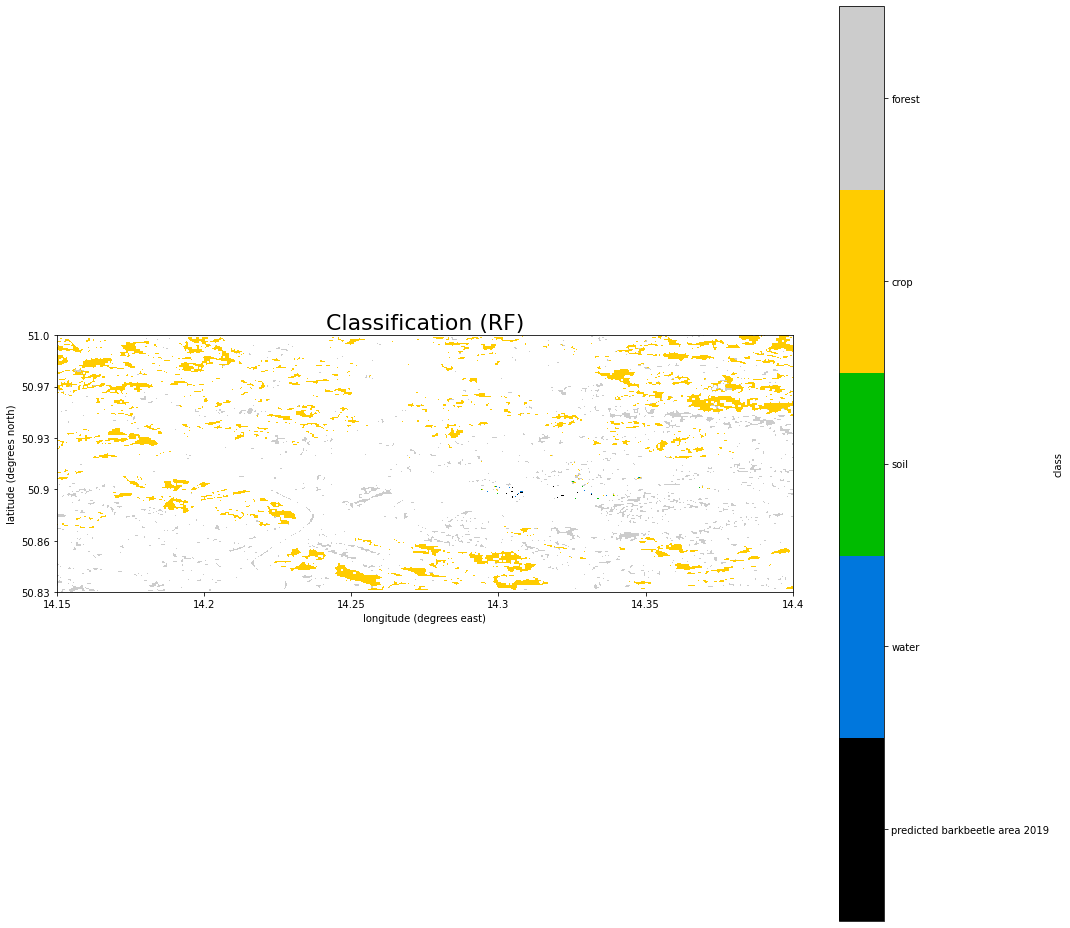

In [53]:
n_class = 5
cmap = plt.cm.get_cmap('nipy_spectral', n_class)  # create colormap
legend_labels = ['predicted barkbeetle area 2019', 'water', 'soil', 'crop', 'forest']  # define legend labels

plotting_lc(ds_pred, variable='classif_rf',n_clusters=n_class, cmap=cmap, legend_labels=legend_labels,
            title='Classification (RF)', save=True, filename='lc_randomforest')

SAVE_FILENAME = 'result.png'
PATH = 'D:\\E4\\1606\\' 
SAVE_PATH = PATH
plt.savefig(SAVE_PATH + SAVE_FILENAME )

In [ ]:
#ÄNDERUNG DER PARAMETER

#NTREE = 300

In [28]:
%%time
# This is a magic function to measure the execution time of a cell, which will be plotted below the cell. It has to be 
# written in the first line of the cell.


# Create a random forest classifier
clf_rf2 = RandomForestClassifier(n_estimators=300)

# Train the model using the training sets 
clf_rf2.fit(X_train,y_train)

# apply the random forest to the test data
y_pred_rf2 = clf_rf2.predict(X_test)

y_pred_rf2

Wall time: 17min 46s


array([21., 21., 21., ..., 21., 21., 21.])

In [29]:
# compute the confusion matrix
# see https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for interpretaion example
metrics.confusion_matrix(y_test, y_pred_rf2) 

array([[  8196,    114,  23546,      0,    142],
       [     0, 452992,      0,      0,   1328],
       [     1,      0, 333124,      0,      0],
       [     0,      0,      0,   5195,      0],
       [     0,    858,      0,      2, 108879]], dtype=int64)

In [34]:
# compute the Kappa coefficient bei ntree = 300
metrics.cohen_kappa_score(y_test, y_pred_rf2)

0.9546576690057256

In [36]:
# compute the overall accuracy bei ntree = 300
metrics.accuracy_score(y_test, y_pred_rf2)

0.972183604690612

In [40]:
# compute a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf2))

              precision    recall  f1-score   support

        10.0       1.00      0.26      0.41     31998
        21.0       1.00      1.00      1.00    454320
        22.0       0.93      1.00      0.97    333125
        23.0       1.00      1.00      1.00      5195
        24.0       0.99      0.99      0.99    109739

    accuracy                           0.97    934377
   macro avg       0.98      0.85      0.87    934377
weighted avg       0.97      0.97      0.97    934377



In [ ]:
#ÄNDERUNG DER PARAMETER

#NTREE = 500

In [33]:
%%time
# This is a magic function to measure the execution time of a cell, which will be plotted below the cell. It has to be 
# written in the first line of the cell.


# Create a random forest classifier
clf_rf3 = RandomForestClassifier(n_estimators=500)

# Train the model using the training sets 
clf_rf3.fit(X_train,y_train)

# apply the random forest to the test data
y_pred_rf3 = clf_rf3.predict(X_test)

y_pred_rf3

Wall time: 29min 45s


array([21., 21., 21., ..., 21., 21., 21.])

In [37]:
# compute the confusion matrix
# see https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for interpretaion example
metrics.confusion_matrix(y_test, y_pred_rf3) 

array([[  8176,    110,  23571,      0,    141],
       [     0, 453001,      0,      0,   1319],
       [     1,      0, 333124,      0,      0],
       [     0,      0,      0,   5195,      0],
       [     0,    895,      0,      2, 108842]], dtype=int64)

In [38]:
# compute the Kappa coefficient bei ntree = 500
metrics.cohen_kappa_score(y_test, y_pred_rf3)

0.9545720980530097

In [39]:
# compute the overall accuracy bei ntree = 500
metrics.accuracy_score(y_test, y_pred_rf3)

0.9721322335631121

In [41]:
# compute a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf3))

              precision    recall  f1-score   support

        10.0       1.00      0.26      0.41     31998
        21.0       1.00      1.00      1.00    454320
        22.0       0.93      1.00      0.97    333125
        23.0       1.00      1.00      1.00      5195
        24.0       0.99      0.99      0.99    109739

    accuracy                           0.97    934377
   macro avg       0.98      0.85      0.87    934377
weighted avg       0.97      0.97      0.97    934377



In [ ]:
#ÄNDERUNG DER PARAMETER

#NTREE = 400

In [42]:
%%time
# This is a magic function to measure the execution time of a cell, which will be plotted below the cell. It has to be 
# written in the first line of the cell.


# Create a random forest classifier
clf_rf4 = RandomForestClassifier(n_estimators=400)

# Train the model using the training sets 
clf_rf4.fit(X_train,y_train)

# apply the random forest to the test data
y_pred_rf4 = clf_rf4.predict(X_test)

y_pred_rf4

Wall time: 24min 33s


array([21., 21., 21., ..., 21., 21., 21.])

In [43]:
# compute the confusion matrix
# see https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for interpretaion example
metrics.confusion_matrix(y_test, y_pred_rf4) 

array([[  8133,    118,  23604,      0,    143],
       [     0, 453004,      0,      0,   1316],
       [     1,      0, 333124,      0,      0],
       [     0,      0,      0,   5195,      0],
       [     0,    876,      0,      2, 108861]], dtype=int64)

In [44]:
# compute the Kappa coefficient bei ntree = 400
metrics.cohen_kappa_score(y_test, y_pred_rf4)

0.9545347856922771

In [45]:
# compute the overall accuracy bei ntree = 400
metrics.accuracy_score(y_test, y_pred_rf4)

0.9721097586948308

In [46]:
# compute a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf4))

              precision    recall  f1-score   support

        10.0       1.00      0.25      0.41     31998
        21.0       1.00      1.00      1.00    454320
        22.0       0.93      1.00      0.97    333125
        23.0       1.00      1.00      1.00      5195
        24.0       0.99      0.99      0.99    109739

    accuracy                           0.97    934377
   macro avg       0.98      0.85      0.87    934377
weighted avg       0.97      0.97      0.96    934377



In [ ]:
#ÄNDERUNG DER PARAMETER

#NTREE = 200

In [47]:
%%time
# This is a magic function to measure the execution time of a cell, which will be plotted below the cell. It has to be 
# written in the first line of the cell.


# Create a random forest classifier
clf_rf5 = RandomForestClassifier(n_estimators=200)

# Train the model using the training sets 
clf_rf5.fit(X_train,y_train)

# apply the random forest to the test data
y_pred_rf5 = clf_rf5.predict(X_test)

y_pred_rf5

Wall time: 12min 1s


array([21., 21., 21., ..., 21., 21., 21.])

In [48]:
# compute the confusion matrix
# see https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for interpretaion example
metrics.confusion_matrix(y_test, y_pred_rf5) 

array([[  8213,    112,  23532,      0,    141],
       [     0, 452960,      0,      0,   1360],
       [     2,      0, 333123,      0,      0],
       [     0,      0,      0,   5195,      0],
       [     0,    903,      0,      2, 108834]], dtype=int64)

In [49]:
# compute the Kappa coefficient bei ntree = 400
metrics.cohen_kappa_score(y_test, y_pred_rf5)

0.9545513335237805

In [50]:
# compute the overall accuracy bei ntree = 400
metrics.accuracy_score(y_test, y_pred_rf5)

0.9721183205494142

In [51]:
# compute a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf5))

              precision    recall  f1-score   support

        10.0       1.00      0.26      0.41     31998
        21.0       1.00      1.00      1.00    454320
        22.0       0.93      1.00      0.97    333125
        23.0       1.00      1.00      1.00      5195
        24.0       0.99      0.99      0.99    109739

    accuracy                           0.97    934377
   macro avg       0.98      0.85      0.87    934377
weighted avg       0.97      0.97      0.97    934377

